# BDT Model Training and Plotting

This notebook (named Chemex, a type of coffeemaker that can also be used to brew tea) combines code from multiple sources in mvatrain (feature_preservation.py, performance_report.py) as well as outside mvatrain (FireHydrant and decaf) to blend training data for BDT models,  and then evaluate those models.

## Dependencies and Directories

Import dependencies:

In [1]:
%matplotlib inline
import os
import time
import json
import uproot
import awkward
import graphviz
import xgboost as xgb
import pandas as pd
import numpy as np
import utils.histoHelpers as uhh
import utils.uprootHelpers as uuh
import mvatrain.preprocessors as mpp
import matplotlib.pyplot as plt
import coffea.processor as processor
from mvatrain.metfilter import *
from awkward import JaggedArray
from os.path import join
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from mvatrain.ROCPlot import ROCPlot
from mvatrain.hist_errorbars import hist_errorbars
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters

Set time strings and directories. TIME_STR and COMBODATA_PATH leads to the combined signal/background dataset. SIGDATA_PATH/BKGDATA_PATH lead to the separated background and signal samples. DATA_DIR is the general data folder for training and sampling. OUTPUT_DIR is the directory with the model. TIME_STR5 is the most recent timestamp, and REPORT_DIR is the directory to dump plots and reports into.

There are multiple models that have been trained with varying training samples and iterations:

**earl_grey** was given the total combo blend of training samples (background + 4mu signal + 2mu2e signal), but trained for a shorter amount of time with fewer iterations.

**earl_grey_strong** was also given the total combo blend of training samples, but trained for a longer amount of time with more iterations.

**english_breakfast** was trained on the 4mu blend (background + 4mu signal), and trained for the longer amount of time.

**irish_breakfast** was trained on the electron blend (background + signal matched to dark photon and electron), and trained for the longer amount of time.

The **redux** version of each model refers to the models that have been trained using fixed data (fixing the maxd0 and mind0 calculations in feature_preservation.py). The old models that were trained on the incorrect data are under the **OUTDATED** folder.

In [11]:
TIME_STR_CURRENT = "190812"
BKGDATA_PATH = join(os.environ["FFANA_BASE"], f"mvatrain/data/bkg_{TIME_STR_CURRENT}.awkd") #background only
SIGDATA_PATH = join(os.environ["FFANA_BASE"], f"mvatrain/data/signal_{TIME_STR_CURRENT}.awkd") #signal only
COMBODATA_PATH = join(os.environ["FFANA_BASE"], f"mvatrain/data/combo_{TIME_STR_CURRENT}.awkd") #combo background and signal
DATA_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/data") #data for training
OUTPUT_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/OUTDATED/earl_grey_strong")  #model
REPORT_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/reports/{TIME_STR_CURRENT}_2") #reports and plots

Load in the model:

In [12]:
print("loading model...")
xgbm_default = xgb.Booster({"nthread": 16})
xgbm_default.load_model(join(OUTPUT_DIR, "model_default/model.bin"))
xgbm_optimized = xgb.Booster({"nthread": 16})
xgbm_optimized.load_model(join(OUTPUT_DIR, "model_optimized/model.bin"))
print("model loaded.")

loading model...
model loaded.


## Blend training data from a .json file

In order to be able to separate signal samples into 2mu2e and 4mu categories (though this can be done directly in feature_preservation.py as well), as well as separate background into its separate samples, we load in filepaths from the 2018.json file:

In [12]:
print("Getting background files from .json...")
datasets_ = json.load(open('2018.json'))
bkgdatasets = {}
for group in datasets_.keys():
    if 'DoubleMuon' in group: continue #not data
    if 'CRAB_PrivateMC' in group: continue #not signal
    files = datasets_[group]['files']
    bkgdatasets[group] = [files] #normal background
            
print("Getting signal files from .json...")
datasets_ = json.load(open('2018.json'))
sigdatasets = []
for group in datasets_.keys():
    if not ('CRAB_PrivateMC' in group): continue #not data or background
    files = datasets_[group]['files']
    for file in files: sigdatasets.append(file)
    
print("Files gotten!")

Getting background files from .json...
Getting signal files from .json...
Files gotten!


Separate the signal files into 2mu2e and 4mu groups:

In [13]:
lssig4mu = []
lssig2mu2e = []

for path in sigdatasets:
    if '4Mu' in path:
        lssig4mu.append(path)
    else:
        lssig2mu2e.append(path)

Take some separated subsets, separated by representative extreme mass points, for consideration:

In [44]:
sig2mu2ephotonmass = []
sig2mu2ephotonmass = []

for path in sig2mu2e:
    if ('MBs-100' in path) and ('MBs-1000' not in path) and ('MDp-5' in path):
        sig2mu2ehighphotonmass.append(path)
    elif ('MBs-1000' in path) and ('MDp-0p25' in path):
        sig2mu2elowphotonmass.append(path)

In [46]:
sig2mu2ehighmidphotonmass = []
sig2mu2elowmidphotonmass = []

for path in sig2mu2e:
    if ('MBs-200' in path) and ('MDp-2p5' in path):
        sig2mu2ehighmidphotonmass.append(path)
    elif ('MBs-500' in path) and ('MDp-0p8' in path):
        sig2mu2elowmidphotonmass.append(path)

Separate the list of background files into each type of background:

In [21]:
DYJets = []
Diboson = []
QCD = []
TTJets = []
Triboson = []

for group in datasets_.keys():
    if 'DoubleMuon' in group: continue
    if 'CRAB_PrivateMC' in group: continue
    for path in bkgdatasets[group][0]:
        if 'DYJets' in group:
            DYJets.append(path)
        elif 'TTJets' in group:
            TTJets.append(path)
        elif 'QCD' in group:
            QCD.append(path)
        elif ('WGG' in group) or ('WWG' in group) or ('WWW' in group) or ('WWZ' in group) or ('WZG' in group) or ('WZZ' in group) or ('ZZZ' in group):
            Triboson.append(path)
        elif ('WW' or 'WZ' or 'ZZ' in group):
            Diboson.append(path)

This next section is taken from feature_preservation.py, and sets up some methods and variables so we can read the filepaths from 2018.json into awkward files:

In [7]:
def match(obj):
    t = obj.tree
    genp4 = uuh.p4Array(t["gen_p4"])
    mDarkPhoton = t["gen_pid"].array() == 32
    mElectron = np.abs(t["gen2_pid"].array()) == 11
    jetp4 = uuh.p4Array(t["pfjet_p4"])
    mGendpMatch, mJetMatch = uuh.MaskArraysFromMatching(genp4[mDarkPhoton][mElectron], jetp4)
    res = mJetMatch[obj.mHLT].flatten()
    return res


def pt(obj):
    t = obj.tree
    return uuh.p4Array(t["pfjet_p4"])[obj.mHLT].pt.flatten()


def eta(obj):
    t = obj.tree
    return uuh.p4Array(t["pfjet_p4"])[obj.mHLT].eta.flatten()


def neutralEnergyFrac(obj):
    t = obj.tree
    jetp4 = uuh.p4Array(t["pfjet_p4"])
    _res = (
        t["pfjet_neutralEmE"].array() + t["pfjet_neutralHadronE"].array()
    ) / jetp4.energy
    return _res[obj.mHLT].flatten()


def pickExtreme(ja, maxmin):
    if ja.size == 0:
        return np.array([])
    if maxmin == "max":
        return np.array([max(x) if x.size else np.nan for x in ja])
    if maxmin == "min":
        return np.array([min(x) if x.size else np.nan for x in ja])
    return np.array([])


def maxd0(obj):
    t = obj.tree
    candTkd0 = np.abs(uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_tkD0"].array())[
        obj.mHLT
    ].flatten())
    return pickExtreme(candTkd0, "max")


def mind0(obj):
    t = obj.tree
    candTkd0 = np.abs(uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_tkD0"].array())[
        obj.mHLT
    ].flatten())
    return pickExtreme(candTkd0, "min")


def n_muon(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    return (np.abs(candType) == 3).sum()


def n_dsa(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    return (np.abs(candType) == 8).sum()


def n_electron(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    return (np.abs(candType) == 2).sum()


def n_photon(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    return (np.abs(candType) == 4).sum()


def energy_muon(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    candEnergy = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_energy"].array())[
        obj.mHLT
    ].flatten()

    return candEnergy[np.abs(candType) == 3].sum()


def energy_dsa(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    candEnergy = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_energy"].array())[
        obj.mHLT
    ].flatten()

    return candEnergy[np.abs(candType) == 8].sum()


def energy_electron(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    candEnergy = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_energy"].array())[
        obj.mHLT
    ].flatten()

    return candEnergy[np.abs(candType) == 2].sum()


def energy_photon(obj):
    t = obj.tree
    candType = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_type"].array())[
        obj.mHLT
    ].flatten()
    candEnergy = uuh.NestNestObjArrayToJagged(t["pfjet_pfcand_energy"].array())[
        obj.mHLT
    ].flatten()

    return candEnergy[np.abs(candType) == 4].sum()


def tkiso(obj):
    return obj.tree["pfjet_tkIsolation05"].array()[obj.mHLT].flatten()


def pfiso(obj):
    return obj.tree["pfjet_pfIsolation05"].array()[obj.mHLT].flatten()


def ptspread(obj):
    return obj.tree["pfjet_ptDistribution"].array()[obj.mHLT].flatten()


def drspread(obj):
    return obj.tree["pfjet_dRSpread"].array()[obj.mHLT].flatten()


def jetsub_lambda(obj):
    return obj.tree["pfjet_subjet_lambda"].array()[obj.mHLT].flatten()


def jetsub_epsilon(obj):
    return obj.tree["pfjet_subjet_epsilon"].array()[obj.mHLT].flatten()


def ecf1(obj):
    return obj.tree["pfjet_subjet_ecf1"].array()[obj.mHLT].flatten()


def ecf2(obj):
    return obj.tree["pfjet_subjet_ecf2"].array()[obj.mHLT].flatten()


def ecf3(obj):
    return obj.tree["pfjet_subjet_ecf3"].array()[obj.mHLT].flatten()


# -----------------------------------------------------------------------------


_pm = {
    "target": match,
    "pt": pt,
    "eta": eta,
    "neufrac": neutralEnergyFrac,
    "maxd0": maxd0,
    "mind0": mind0,
    # "nmuo": n_muon,
    # "ndsa": n_dsa,
    # "nele": n_electron,
    # "npho": n_photon,
    # "energymuo": energy_muon,
    # "energydsa": energy_dsa,
    # "energyele": energy_electron,
    # "energypho": energy_photon,
    "tkiso": tkiso,
    "pfiso": pfiso,
    "spreadpt": ptspread,
    "spreaddr": drspread,
    "lambda": jetsub_lambda,
    "epsilon": jetsub_epsilon,
    "ecf1": ecf1,
    "ecf2": ecf2,
    "ecf3": ecf3,
}

Again, this section is modified from feature_preservation.py, and reads through the files picked from 2018.json, and runs over them to create awkward files of separated 2mu2e and 4mu signal files.

In [10]:
mp4mu = mpp.ffMultiPicker(sig4mu, pickmethods=_pm)
mp_res_4mu = mp4mu.pick()

mp2mu2e = mpp.ffMultiPicker(sig2mu2e, pickmethods=_pm)
mp_res_2mu2e = mp2mu2e.pick()

fn4mu = "signal_4mu_{}.awkd".format(TIME_STR3)
fn2mu2e = "signal_2mu2e_{}.awkd".format(TIME_STR3)

fn4mu = os.path.join(DATA_DIR, fn4mu)
fn2mu2e = os.path.join(DATA_DIR, fn2mu2e)
awkward.save(fn4mu, mp_res_4mu, mode="w")
awkward.save(fn2mu2e, mp_res_2mu2e, mode="w")

Do the same thing for the mass point subsets:

In [8]:
mphigh = mpp.ffMultiPicker(sig2mu2ehighphotonmass, pickmethods=_pm)
mp_res_high = mphigh.pick()

mplow = mpp.ffMultiPicker(sig2mu2elowphotonmass, pickmethods=_pm)
mp_res_low = mphigh.pick()

fnhigh = "signal_2mu2e_MBs100_MDp5_{}.awkd".format(TIME_STR6)
fnlow = "signal_2mu2e_MBs1000_MDp0p25_{}.awkd".format(TIME_STR6)

fnhigh = os.path.join(DATA_DIR, fnhigh)
fnlow = os.path.join(DATA_DIR, fnlow)
awkward.save(fnhigh, mp_res_high, mode="w")
awkward.save(fnlow, mp_res_low, mode="w")

In [47]:
mphighmid = mpp.ffMultiPicker(sig2mu2ehighmidphotonmass, pickmethods=_pm)
mp_res_highmid = mphighmid.pick()

mplowmid = mpp.ffMultiPicker(sig2mu2elowmidphotonmass, pickmethods=_pm)
mp_res_lowmid = mplowmid.pick()

fnhighmid = "signal_2mu2e_MBs200_MDp2p5_{}.awkd".format(TIME_STR8)
fnlowmid = "signal_2mu2e_MBs500_MDp0p8_{}.awkd".format(TIME_STR8)

fnhighmid = os.path.join(DATA_DIR, fnhighmid)
fnlowmid = os.path.join(DATA_DIR, fnlowmid)
awkward.save(fnhighmid, mp_res_highmid, mode="w")
awkward.save(fnlowmid, mp_res_lowmid, mode="w")

Do the same thing for background, creating awkward files for each type of background:

In [17]:
_pm.pop("target")

DYmp = mpp.ffMultiPicker(DYJets, pickmethods=_pm)
mp_res_DY = DYmp.pick()
mp_res_DY["target"] = np.zeros(len(mp_res_DY["pt"]), dtype=bool)

Diboson_mp = mpp.ffMultiPicker(Diboson, pickmethods=_pm)
mp_res_diboson = Diboson_mp.pick()
mp_res_diboson["target"] = np.zeros(len(mp_res_diboson["pt"]), dtype=bool)

QCDmp = mpp.ffMultiPicker(QCD, pickmethods=_pm)
mp_res_QCD = QCDmp.pick()
mp_res_QCD["target"] = np.zeros(len(mp_res_QCD["pt"]), dtype=bool)

TTmp = mpp.ffMultiPicker(TTJets, pickmethods=_pm)
mp_res_TT = TTmp.pick()
mp_res_TT["target"] = np.zeros(len(mp_res_TT["pt"]), dtype=bool)

Triboson_mp = mpp.ffMultiPicker(Triboson, pickmethods=_pm)
mp_res_triboson = Triboson_mp.pick()
mp_res_triboson["target"] = np.zeros(len(mp_res_triboson["pt"]), dtype=bool)

fndy = "bkg_dyjets_{}.awkd".format(TIME_STR3)
fndiboson = "bkg_diboson_{}.awkd".format(TIME_STR3)
fnqcd = "bkg_qcd_{}.awkd".format(TIME_STR3)
fntt = "bkg_ttjets_{}.awkd".format(TIME_STR3)
fntriboson = "bkg_triboson_{}.awkd".format(TIME_STR3)

fndy = os.path.join(DATA_DIR, fndy)
fndiboson = os.path.join(DATA_DIR, fndiboson)
fnqcd = os.path.join(DATA_DIR, fnqcd)
fntt = os.path.join(DATA_DIR, fntt)
fntriboson = os.path.join(DATA_DIR, fntriboson)

awkward.save(fndy, mp_res_DY, mode="w")
awkward.save(fndiboson, mp_res_diboson, mode="w")
awkward.save(fnqcd, mp_res_QCD, mode="w")
awkward.save(fntt, mp_res_TT, mode="w")
awkward.save(fntriboson, mp_res_triboson, mode="w")

## Using a previously generated model to make and plot predictions

In this section, we generate prediction distributions and other performance report plots and metrics.

Run over those awkward signal files and do predictions:

In [11]:
PATH_2MU2E = join(os.environ["FFANA_BASE"], f"mvatrain/data/signal_2mu2e_{TIME_STR3}.awkd")
PATH_4MU = join(os.environ["FFANA_BASE"], f"mvatrain/data/signal_4mu_{TIME_STR3}.awkd")

print("loading data...")
dataset_ = awkward.load(COMBODATA_PATH)
dataset_2mu2e_ = awkward.load(PATH_2MU2E)
dataset_4mu_ = awkward.load(PATH_4MU)
df = pd.DataFrame(dict(dataset_))
df2mu2e = pd.DataFrame(dict(dataset_2mu2e_))
df4mu = pd.DataFrame(dict(dataset_4mu_))
df.fillna(0)
df2mu2e.fillna(0)
df4mu.fillna(0)

feature_cols_2mu2e = [n for n in dataset_2mu2e_.keys() if n != "target"]
feature_cols_4mu = [n for n in dataset_4mu_.keys() if n != "target"]

X_train_2mu2e, X_test_2mu2e, y_train_2mu2e, y_test_2mu2e = train_test_split(
    df2mu2e[feature_cols_2mu2e], df2mu2e["target"], random_state=42, test_size=0.25
)
X_train_4mu, X_test_4mu, y_train_4mu, y_test_4mu = train_test_split(
    df4mu[feature_cols_4mu], df4mu["target"], random_state=42, test_size=0.25
)

xgtrain2mu2e = xgb.DMatrix(X_train_2mu2e, label=y_train_2mu2e)
xgtest2mu2e = xgb.DMatrix(X_test_2mu2e, label=y_test_2mu2e)
xgtrain4mu = xgb.DMatrix(X_train_4mu, label=y_train_4mu)
xgtest4mu = xgb.DMatrix(X_test_4mu, label=y_test_4mu)

train_preds_optimized_2mu2e = xgbm_optimized.predict(xgtrain2mu2e)
test_preds_optimized_2mu2e = xgbm_optimized.predict(xgtest2mu2e)

train_preds_optimized_4mu = xgbm_optimized.predict(xgtrain4mu)
test_preds_optimized_4mu = xgbm_optimized.predict(xgtest4mu)

print("data loaded.")

loading data...


/uscms/home/sadie/nobackup/anaconda3/envs/ffAna/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


data loaded.


Plot BDT value for separated 2mu2e and 4mu signal samples:

In [12]:
if not os.path.exists(REPORT_DIR):
    os.makedirs(REPORT_DIR)

print(f"Making prediction distribution plots under {REPORT_DIR}")
commonkw = {
    "range": [-10, 10],
    "bins": 50,
    "histtype": "stepfilled",
    "alpha": 0.8,
    "density": True,
    "linewidth": 2,
}

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(train_preds_optimized_2mu2e[y_train_2mu2e], label="signal 2mu2e (train)", **commonkw)
commonkw.pop("histtype")
commonkw.pop("alpha")
hist_errorbars(test_preds_optimized_2mu2e[y_test_2mu2e], ax=ax, **commonkw).set_label(
    "signal 2mu2e (test)"
)

ax.legend(title="optimized")
ax.set_xlabel("BDT score", ha="right", x=1)
ax.set_ylabel("A.U.", ha="right", y=1)
ax.set_title("leptonJet BDT prediction value", ha="left", x=0)
plt.savefig(join(REPORT_DIR, "signal_2mu2e_prediction_dist_optimized.pdf"), bbox_inches='tight')
plt.close()

commonkw.update({"range": [-10, 10], "histtype": "stepfilled", "alpha": 0.8})
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(train_preds_optimized_4mu[y_train_4mu], label="signal 4mu (train)", **commonkw)
commonkw.pop("histtype")
commonkw.pop("alpha")
hist_errorbars(test_preds_optimized_4mu[y_test_4mu], ax=ax, **commonkw).set_label(
    "signal 4mu (test)"
)

ax.legend(title="optimized")
ax.set_xlabel("BDT score", ha="right", x=1)
ax.set_ylabel("A.U.", ha="right", y=1)
ax.set_title("leptonJet BDT prediction value", ha="left", x=0)
plt.savefig(join(REPORT_DIR, "signal_4mu_prediction_dist_optimized.pdf"), bbox_inches='tight')
plt.close()

print("Plots made!")

Making prediction distribution plots under /uscms/home/sadie/nobackup/ffAna-master/mvatrain/reports/190730
Plots made!


Overlay the two signal samples into the same plot:

In [13]:
if not os.path.exists(REPORT_DIR):
    os.makedirs(REPORT_DIR)

print(f"Making prediction distribution plots under {REPORT_DIR}")
commonkw = {
    "range": [-10, 10],
    "bins": 50,
    "histtype": "stepfilled",
    "alpha": 0.8,
    "density": True,
    "linewidth": 2,
}

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(train_preds_optimized_2mu2e[y_train_2mu2e], label="signal 2mu2e (train)", **commonkw)
ax.hist(train_preds_optimized_4mu[y_train_4mu], label="signal 4mu (train)", **commonkw)
commonkw.pop("histtype")
commonkw.pop("alpha")
hist_errorbars(test_preds_optimized_2mu2e[y_test_2mu2e], ax=ax, **commonkw).set_label(
    "signal 2mu2e (test)"
)
hist_errorbars(test_preds_optimized_4mu[y_test_4mu], ax=ax, **commonkw).set_label(
    "signal 4mu (test)"
)

ax.legend(title="optimized")
ax.set_xlabel("BDT score", ha="right", x=1)
ax.set_ylabel("A.U.", ha="right", y=1)
ax.set_title("leptonJet BDT prediction value", ha="left", x=0)
plt.savefig(join(REPORT_DIR, "signal_overlay_prediction_dist_optimized.pdf"), bbox_inches='tight')
plt.close()

print("Plots made!")

Making prediction distribution plots under /uscms/home/sadie/nobackup/ffAna-master/mvatrain/reports/190730
Plots made!


Do predictions over each type of background:

In [18]:
PATH_DY = join(os.environ["FFANA_BASE"], f"mvatrain/data/bkg_dyjets_{TIME_STR3}.awkd")
PATH_DIBOSON = join(os.environ["FFANA_BASE"], f"mvatrain/data/bkg_diboson_{TIME_STR3}.awkd")
PATH_QCD = join(os.environ["FFANA_BASE"], f"mvatrain/data/bkg_qcd_{TIME_STR3}.awkd")
PATH_TT = join(os.environ["FFANA_BASE"], f"mvatrain/data/bkg_ttjets_{TIME_STR3}.awkd")
PATH_TRIBOSON = join(os.environ["FFANA_BASE"], f"mvatrain/data/bkg_triboson_{TIME_STR3}.awkd")

print("loading data...")
dataset_dy_ = awkward.load(PATH_DY)
dataset_diboson_ = awkward.load(PATH_DIBOSON)
dataset_qcd_ = awkward.load(PATH_QCD)
dataset_tt_ = awkward.load(PATH_TT)
dataset_triboson_ = awkward.load(PATH_TRIBOSON)
dfdy = pd.DataFrame(dict(dataset_dy_))
dfdiboson = pd.DataFrame(dict(dataset_diboson_))
dfqcd = pd.DataFrame(dict(dataset_qcd_))
dftt = pd.DataFrame(dict(dataset_tt_))
dftriboson = pd.DataFrame(dict(dataset_triboson_))
dfdy.fillna(0)
dfdiboson.fillna(0)
dfqcd.fillna(0)
dftt.fillna(0)
dftriboson.fillna(0)

feature_cols_dy = [n for n in dataset_dy_.keys() if n != "target"]
feature_cols_diboson = [n for n in dataset_diboson_.keys() if n != "target"]
feature_cols_qcd = [n for n in dataset_qcd_.keys() if n != "target"]
feature_cols_tt = [n for n in dataset_tt_.keys() if n != "target"]
feature_cols_triboson = [n for n in dataset_triboson_.keys() if n != "target"]

X_train_dy, X_test_dy, y_train_dy, y_test_dy = train_test_split(
    dfdy[feature_cols_dy], dfdy["target"], random_state=42, test_size=0.25
)
X_train_diboson, X_test_diboson, y_train_diboson, y_test_diboson = train_test_split(
    dfdiboson[feature_cols_diboson], dfdiboson["target"], random_state=42, test_size=0.25
)
X_train_qcd, X_test_qcd, y_train_qcd, y_test_qcd = train_test_split(
    dfqcd[feature_cols_qcd], dfqcd["target"], random_state=42, test_size=0.25
)
X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(
    dftt[feature_cols_tt], dftt["target"], random_state=42, test_size=0.25
)
X_train_triboson, X_test_triboson, y_train_triboson, y_test_triboson = train_test_split(
    dftriboson[feature_cols_triboson], dftriboson["target"], random_state=42, test_size=0.25
)

xgtraindy = xgb.DMatrix(X_train_dy, label=y_train_dy)
xgtestdy = xgb.DMatrix(X_test_dy, label=y_test_dy)
xgtraindiboson = xgb.DMatrix(X_train_diboson, label=y_train_diboson)
xgtestdiboson = xgb.DMatrix(X_test_diboson, label=y_test_diboson)
xgtrainqcd = xgb.DMatrix(X_train_qcd, label=y_train_qcd)
xgtestqcd = xgb.DMatrix(X_test_qcd, label=y_test_qcd)
xgtraintt = xgb.DMatrix(X_train_tt, label=y_train_tt)
xgtesttt = xgb.DMatrix(X_test_tt, label=y_test_tt)
xgtraintriboson = xgb.DMatrix(X_train_triboson, label=y_train_triboson)
xgtesttriboson = xgb.DMatrix(X_test_triboson, label=y_test_triboson)

train_preds_optimized_dy = xgbm_optimized.predict(xgtraindy)
test_preds_optimized_dy = xgbm_optimized.predict(xgtestdy)

train_preds_optimized_diboson = xgbm_optimized.predict(xgtraindiboson)
test_preds_optimized_diboson = xgbm_optimized.predict(xgtestdiboson)

train_preds_optimized_qcd = xgbm_optimized.predict(xgtrainqcd)
test_preds_optimized_qcd = xgbm_optimized.predict(xgtestqcd)

train_preds_optimized_tt = xgbm_optimized.predict(xgtraintt)
test_preds_optimized_tt = xgbm_optimized.predict(xgtesttt)

train_preds_optimized_triboson = xgbm_optimized.predict(xgtraintriboson)
test_preds_optimized_triboson = xgbm_optimized.predict(xgtesttriboson)

print("data loaded.")

loading data...


/uscms/home/sadie/nobackup/anaconda3/envs/ffAna/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


data loaded.


Plot different types of background (background overlay is not working, but is a moot point since coffea integration is now working):

In [55]:
print(f"Making prediction distribution plots under {REPORT_DIR}")
commonkw = {
    "range": [-10, 10],
    "bins": 50,
    "histtype": "stepfilled",
    "alpha": 0.8,
    "density": True,
    "linewidth": 2,
}

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(train_preds_optimized_triboson, label="background triboson (train)", **commonkw)

commonkw.pop("histtype")
commonkw.pop("alpha")

hist_errorbars(test_preds_optimized_triboson, ax=ax, **commonkw).set_label(
    "background triboson (test)"
)

ax.legend(title="optimized")
ax.set_xlabel("BDT score", ha="right", x=1)
ax.set_ylabel("A.U.", ha="right", y=1)
ax.set_title("leptonJet BDT prediction value", ha="left", x=0)
plt.savefig(join(REPORT_DIR, "background_triboson_overlay_prediction_dist_optimized.pdf"), bbox_inches='tight')
plt.close()

print("Plots made!")

Making prediction distribution plots under /uscms/home/sadie/nobackup/ffAna-master/mvatrain/reports/190729
Plots made!


## Reference: Prediction from .awkd

Keep our code that predicts straight from an awkward file, just in case we need it.

In [15]:
PATH_SIG = join(os.environ["FFANA_BASE"], f"mvatrain/data/signal_190813.awkd")

test_dataset_ = awkward.load(PATH_SIG)
dftest = pd.DataFrame(dict(test_dataset_))
dftest.fillna(0)

feature_cols = [n for n in test_dataset_.keys() if n != "target"]
dftest2 = dftest[feature_cols]

xgtest = xgb.DMatrix(dftest2)

preds = xgbm_optimized.predict(xgtest)

## Implementation of Coffea processing and histogramming

To gain access to an increased amount of histogramming tools and plotting capabilities, we want to interface the BDT (which is not saved in the ntuples here) with Coffea's processor tool.

This notebook is getting long, so let's recall our timestamps and load in our desired model again:

In [2]:
np.seterr(divide='ignore', invalid='ignore', over='ignore')
np.set_printoptions(threshold=np.inf)
TIME_STR = "190812"
TIME_STR2 = "190815"
TIME_STR_CURRENT = "190822"
DATA_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/data") #base data directory
OUTPUT_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/earl_grey_strong_redux")  #model
REPORT_DIR = join(os.environ["FFANA_BASE"], f"mvatrain/reports/{TIME_STR_CURRENT}") #reports and plots

In [3]:
OUTPUT_DIR_CURRENT = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/earl_grey_strong_redux")
OUTPUT_DIR_MU = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/english_breakfast_redux")
OUTPUT_DIR_ELEC = join(os.environ["FFANA_BASE"], f"mvatrain/outputs/irish_breakfast_redux")

print("loading model...")
xgbm_current = xgb.Booster({"nthread": 16})
xgbm_current.load_model(join(OUTPUT_DIR_CURRENT, "model_optimized/model.bin"))
if xgbm_current.attributes().get('SAVED_PARAM_predictor', None)=='gpu_predictor':
    xgbm_current.set_attr(SAVED_PARAM_predictor=None)
print("model loaded.")

print("loading model...")
xgbm_mu = xgb.Booster({"nthread": 16})
xgbm_mu.load_model(join(OUTPUT_DIR_MU, "model_optimized/model.bin"))
if xgbm_mu.attributes().get('SAVED_PARAM_predictor', None)=='gpu_predictor':
    xgbm_mu.set_attr(SAVED_PARAM_predictor=None)
print("model loaded.")

print("loading model...")
xgbm_elec = xgb.Booster({"nthread": 16})
xgbm_elec.load_model(join(OUTPUT_DIR_ELEC, "model_optimized/model.bin"))
if xgbm_elec.attributes().get('SAVED_PARAM_predictor', None)=='gpu_predictor':
    xgbm_elec.set_attr(SAVED_PARAM_predictor=None)
print("model loaded.")

loading model...
model loaded.
loading model...
model loaded.
loading model...
model loaded.


We can also make graphviz representations of the model, if we want:

In [24]:
graphviz_current_1 = xgb.to_graphviz(xgbm_current, num_trees=1)
graphviz_mu_1 = xgb.to_graphviz(xgbm_mu, num_trees=1)
graphviz_elec_1 = xgb.to_graphviz(xgbm_elec, num_trees=1)

In [25]:
graphviz_current_1.render(filename="current_1.gv")
graphviz_mu_1.render(filename="mu_1.gv")
graphviz_elec_1.render(filename="elec_1.gv")

'elec_1.gv.pdf'

Get our data from .json and sort it:

In [4]:
print("Getting background files from .json...")
datasets_ = json.load(open('2018.json'))
bkgdatasets = {}
for group in datasets_.keys():
    if 'DoubleMuon' in group: continue #not data
    if 'CRAB_PrivateMC' in group: continue #not signal
    files = datasets_[group]['files']
    bkgdatasets[group] = [files] #normal background
            
print("Getting signal files from .json...")
datasets_ = json.load(open('2018.json'))
sigdatasets = []
for group in datasets_.keys():
    if not ('CRAB_PrivateMC' in group): continue #not data or background
    files = datasets_[group]['files']
    for file in files: sigdatasets.append(file)
    
print("Files gotten!")

Getting background files from .json...
Getting signal files from .json...
Files gotten!


In [5]:
lssig4mu = []
lssig2mu2e = []

for path in sigdatasets:
    if '4Mu' in path:
        lssig4mu.append(path)
    else:
        lssig2mu2e.append(path)

In [6]:
dataset=dict(
    sig4mu={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

dataset['sig4mu']['files'].extend(lssig4mu)
dataset['sig2mu2e']['files'].extend(lssig2mu2e)

In [7]:
dataset_mu=dict(
    sig4mu={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)
dataset_elec=dict(
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

dataset_mu['sig4mu']['files'].extend(lssig4mu)
dataset_elec['sig2mu2e']['files'].extend(lssig2mu2e)

So now we can start setting up our coffea processor. We include the "making predictions" step right in the processor, and then back-save the predictions alongside the other data so that the prediction value is matched with its event.

In [8]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis  = hist.Cat('dataset', 'signal datasets')
        match_axis    = hist.Cat('match', 'matched')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        neufrac_axis  = hist.Bin("neufrac", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lambda', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsilon', 'jet sub - epsilon', 50, 0, 0.25)
        ecf1_axis     = hist.Bin('ecf1', 'energy correlation function - e1', 50, 0, 750)
        ecf2_axis     = hist.Bin('ecf2', 'energy correlation function - e2', 50, 0, 2000)
        ecf3_axis     = hist.Bin('ecf3', 'energy correlation function - e3', 50, 0, 1000)
        mva_axis      = hist.Bin('mva', "BDT prediction value", 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, match_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, match_axis),
            "neufrac": hist.Hist("#counts/0.02", dataset_axis, neufrac_axis, match_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, match_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, match_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, match_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, match_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, match_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, match_axis),
            "lambda": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, match_axis),
            "epsilon": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, match_axis),
            "ecf1": hist.Hist("#counts/25", dataset_axis, ecf1_axis, match_axis),
            "ecf2": hist.Hist("#counts/40", dataset_axis, ecf2_axis, match_axis),
            "ecf3": hist.Hist("#counts/20", dataset_axis, ecf3_axis, match_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, match_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(-10000).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(10000).min()
        
        flat_maxd0 = maxd0_.flatten()
        offsets = maxd0_.offsets
        flat_maxd0 = np.where(flat_maxd0 == -10000, 0, flat_maxd0)
        maxd0_ = JaggedArray.fromoffsets(offsets, flat_maxd0)
        
        flat_mind0 = mind0_.flatten()
        offsets = mind0_.offsets
        flat_mind0 = np.where(flat_mind0 == 10000, 0, flat_mind0)
        mind0_ = JaggedArray.fromoffsets(offsets, flat_mind0)
                            
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'].content,
            "py": df['pfjet_p4.fCoordinates.fY'].content,
            "pz": df['pfjet_p4.fCoordinates.fZ'].content,
            "energy": df['pfjet_p4.fCoordinates.fT'].content,
            "neufrac": ((df['pfjet_neutralEmE'].content+df['pfjet_neutralHadronE'].content)/df['pfjet_p4.fCoordinates.fT'].content),
            "maxd0": maxd0_.content,
            "mind0": mind0_.content,
            "tkiso": df['pfjet_tkIsolation05'].content,
            "pfiso": df['pfjet_pfIsolation05'].content,
            "spreadpt": df['pfjet_ptDistribution'].content,
            "spreaddr": df['pfjet_dRSpread'].content,
            "lambda": df['pfjet_subjet_lambda'].content,
            "epsilon": df['pfjet_subjet_epsilon'].content,
            "ecf1": df['pfjet_subjet_ecf1'].content,
            "ecf2": df['pfjet_subjet_ecf2'].content,
            "ecf3": df['pfjet_subjet_ecf3'].content,
            })
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content
        )
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
        }
        
        vals.update( {k: leptonjets[k].flatten() for k in output.keys() if (k not in vals and k != 'mva')} )
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_current.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_t = leptonjets[matchmask][metfiltermask&triggermask]
        leptonjets_f = leptonjets[~matchmask][metfiltermask&triggermask]
        
        output['pt']      .fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='matched', eta=leptonjets_t.eta.flatten())
        output['neufrac'] .fill(dataset=dataset, match='matched', neufrac=leptonjets_t.neufrac.flatten())
        output['maxd0']   .fill(dataset=dataset, match='matched', maxd0=leptonjets_t.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='matched', mind0=leptonjets_t.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='matched', tkiso=leptonjets_t.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='matched', pfiso=leptonjets_t.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='matched', spreadpt=leptonjets_t.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='matched', spreaddr=leptonjets_t.spreaddr.flatten())
        output['lambda']  .fill(**{"dataset": dataset, "match": 'matched', "lambda": leptonjets_t['lambda'].flatten()})
        output['epsilon'] .fill(dataset=dataset, match='matched', epsilon=leptonjets_t.epsilon.flatten())
        output['ecf1']    .fill(dataset=dataset, match='matched', ecf1=leptonjets_t.ecf1.flatten())
        output['ecf2']    .fill(dataset=dataset, match='matched', ecf2=leptonjets_t.ecf2.flatten())
        output['ecf3']    .fill(dataset=dataset, match='matched', ecf3=leptonjets_t.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='matched', mva=leptonjets_t['mva'].flatten())
        
        output['pt']      .fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='unmatched', eta=leptonjets_f.eta.flatten())
        output['neufrac'] .fill(dataset=dataset, match='unmatched', neufrac=leptonjets_f.neufrac.flatten())
        output['maxd0']   .fill(dataset=dataset, match='unmatched', maxd0=leptonjets_f.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='unmatched', mind0=leptonjets_f.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='unmatched', tkiso=leptonjets_f.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='unmatched', pfiso=leptonjets_f.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='unmatched', spreadpt=leptonjets_f.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='unmatched', spreaddr=leptonjets_f.spreaddr.flatten())
        output['lambda']  .fill(**{"dataset": dataset, "match": 'unmatched', "lambda": leptonjets_f['lambda'].flatten()})
        output['epsilon'] .fill(dataset=dataset, match='unmatched', epsilon=leptonjets_f.epsilon.flatten())
        output['ecf1']    .fill(dataset=dataset, match='unmatched', ecf1=leptonjets_f.ecf1.flatten())
        output['ecf2']    .fill(dataset=dataset, match='unmatched', ecf2=leptonjets_f.ecf2.flatten())
        output['ecf3']    .fill(dataset=dataset, match='unmatched', ecf3=leptonjets_f.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='unmatched', mva=leptonjets_f['mva'].flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [9]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000
                                 )

Processing: 100%|██████████| 300/300 [01:04<00:00,  3.72items/s]


Now we can plot anything we want, just as if the BDT value had been saved into the ntuples! Let's look at $P_t$ to make sure our plotting is working correctly: 

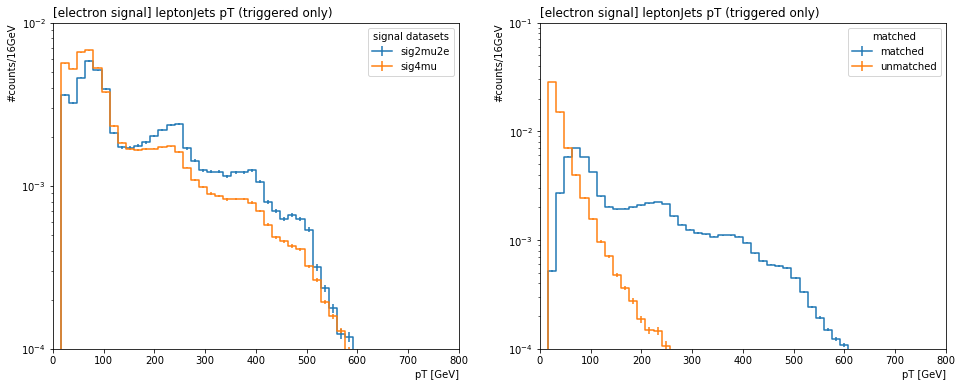

In [10]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[electron signal] leptonJets pT (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

And now we can plot BDT prediction values:

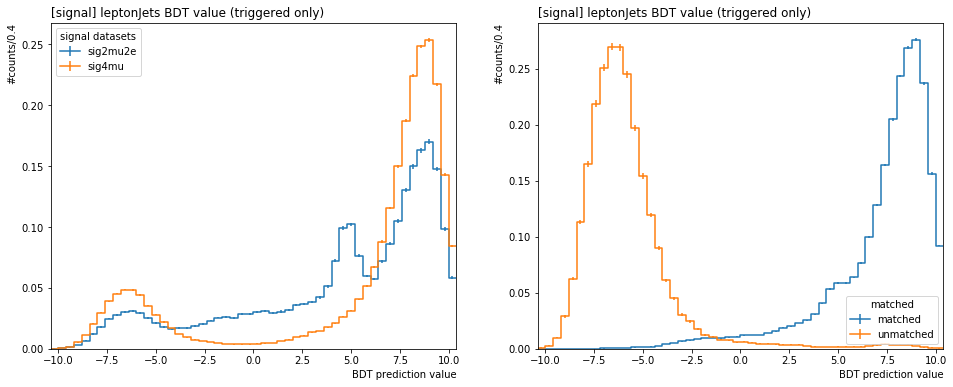

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mva'].project('match'), overlay='dataset', ax=axes[0], density=True, overflow='all')
fig, ax, _ = hist.plot1d(output['mva'].project('dataset'), overlay='match', ax=axes[1], density=True, overflow='all')

for ax in axes:
    ax.set_title('[signal] leptonJets BDT value (triggered only)', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## Counts and Cuts: Sorted with Gen Matching

Now we want to get a more detailed sense of the effectiveness of each model, so we'll use a combination of count plotting and coffea's cutflow to tell us how many leptonJets are passing the cut points for each model.

This is the section that was used to generate the numbers for my slides given in the 8/22/19 update meeting. Those plots were made using a lot of different processors (with the corresponding models, etc.) but for the sake of shortening this notebook, a single representative processor and plot has been included, with alternate options for models and cuts etc. commented in. You can mix and match models and separation methods to generate all the plots and numbers in the 8/22/19 slides.

LJs that pass cuts, current model vs total signal:

In [12]:
class LeptonJetCountProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis  = hist.Cat('dataset', 'signal datasets')
        count_axis = hist.Bin("count", "#pass BDT threshold", 9, 0, 9)
        
        self._accumulator = processor.dict_accumulator({
            'count': hist.Hist("Counts", dataset_axis, count_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(-10000).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(10000).min()
        
        flat_maxd0 = maxd0_.flatten()
        offsets = maxd0_.offsets
        flat_maxd0 = np.where(flat_maxd0 == -10000, 0, flat_maxd0)
        maxd0_ = JaggedArray.fromoffsets(offsets, flat_maxd0)
        
        flat_mind0 = mind0_.flatten()
        offsets = mind0_.offsets
        flat_mind0 = np.where(flat_mind0 == 10000, 0, flat_mind0)
        mind0_ = JaggedArray.fromoffsets(offsets, flat_mind0)
                            
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'], **{
            "px": df['pfjet_p4.fCoordinates.fX'].content,
            "py": df['pfjet_p4.fCoordinates.fY'].content,
            "pz": df['pfjet_p4.fCoordinates.fZ'].content,
            "energy": df['pfjet_p4.fCoordinates.fT'].content,
            "neufrac": ((df['pfjet_neutralEmE'].content+df['pfjet_neutralHadronE'].content)/df['pfjet_p4.fCoordinates.fT'].content),
            "maxd0": maxd0_.content,
            "mind0": mind0_.content,
            "tkiso": df['pfjet_tkIsolation05'].content,
            "pfiso": df['pfjet_pfIsolation05'].content,
            "spreadpt": df['pfjet_ptDistribution'].content,
            "spreaddr": df['pfjet_dRSpread'].content,
            "lambda": df['pfjet_subjet_lambda'].content,
            "epsilon": df['pfjet_subjet_epsilon'].content,
            "ecf1": df['pfjet_subjet_ecf1'].content,
            "ecf2": df['pfjet_subjet_ecf2'].content,
            "ecf3": df['pfjet_subjet_ecf3'].content,
            })
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content
        )
        
        vals={
            'target': leptonjets.pt.zeros_like().flatten(),
            'pt': leptonjets.pt.flatten(),
            'eta': leptonjets.eta.flatten(),
            "neufrac": leptonjets.neufrac.flatten(),
            "maxd0": leptonjets.maxd0.flatten(),
            "mind0": leptonjets.mind0.flatten(),
            "tkiso": leptonjets.tkiso.flatten(),
            "pfiso": leptonjets.pfiso.flatten(),
            "spreadpt": leptonjets.spreadpt.flatten(),
            "spreaddr": leptonjets.spreaddr.flatten(),
            "lambda": leptonjets['lambda'].flatten(),
            "epsilon": leptonjets.epsilon.flatten(),
            "ecf1": leptonjets.ecf1.flatten(),
            "ecf2": leptonjets.ecf2.flatten(),
            "ecf3": leptonjets.ecf3.flatten()
        }
        
        dfleptonjets = pd.DataFrame(vals)
        
        dfleptonjets.fillna(0)
        
        feature_cols = [n for n in dfleptonjets.keys() if n != "target"]

        dfleptonjets2 = dfleptonjets[feature_cols]
        
        xglj = xgb.DMatrix(dfleptonjets2)
        
        predictions = xgbm_current.predict(xglj)
        # or predictions = xgbm_elec.predict(xglj)
        # or predictions = xgbm_mu.predict(xglj)
        
        offsets = leptonjets.pt.offsets
        jaggedpredictions = JaggedArray.fromoffsets(offsets, predictions)
        leptonjets.add_attributes(mva=jaggedpredictions)
        
        output['cutflow']['all jets'] += leptonjets.pt.flatten().size
        
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        #or, to select electrons/muons via gen matching:
        #darkphotons = genparticles[genparticles.pid==32]
        #electrons = genparticles[genparticles.pid==11] <-- or for muons, genparticles.pid==13
        #leptonjets = leptonjets[leptonjets.match(electrons, deltaRCut=0.3)]
        #output['cutflow']['pass electron match'] += leptonjets.pt.flatten().size
        #matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        #or, to select electrons/muons via a kinematic cut such as nef:
        #elecmask = leptonjets.neufrac > 0.8 <-- or for muons, leptonjets.neufrac <= 0.8
        #leptonjets = leptonjets[elecmask]
        #output['cutflow']['pass neufrac cut'] += leptonjets.pt.flatten().size
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets = leptonjets[matchmask]
        output['cutflow']['pass dark photon matching'] += leptonjets.pt.flatten().size
        leptonjets = leptonjets[metfiltermask&triggermask]
        output['cutflow']['pass trigger and MET filter'] += leptonjets.pt.flatten().size
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        #the values below come from the corresponding performance report of the model, giving 1%, 0.1%, and 0.01% fake
        #rate respectively. they are extracted from the ROC curve and can be found in the text report.
        looseval = 1.146255612373352
        mediumval = 5.309855937957764
        tightval = 8.649089813232422
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            passloosecounts = (leadingLjPair.i0.mva>looseval).astype(int)+(leadingLjPair.i1.mva>looseval).astype(int)
            passmediumcounts = (leadingLjPair.i0.mva>mediumval).astype(int)+(leadingLjPair.i1.mva>mediumval).astype(int)
            passtightcounts = (leadingLjPair.i0.mva>tightval).astype(int)+(leadingLjPair.i1.mva>tightval).astype(int)
            
            output['count'].fill(dataset=dataset, count=passloosecounts.flatten())
            output['count'].fill(dataset=dataset, count=(passmediumcounts.flatten())+3)
            output['count'].fill(dataset=dataset, count=(passtightcounts.flatten())+6)

        loose = leptonjets[leptonjets.mva>looseval]
        medium = leptonjets[leptonjets.mva>mediumval]
        tight = leptonjets[leptonjets.mva>tightval]
        
        output['cutflow']['pass loose cut'] += loose.pt.flatten().size
        output['cutflow']['pass medium cut'] += medium.pt.flatten().size
        output['cutflow']['pass tight cut'] += tight.pt.flatten().size
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [13]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetCountProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12),
                                  chunksize=500000
                                 )

Processing: 100%|██████████| 300/300 [01:04<00:00,  3.92items/s]


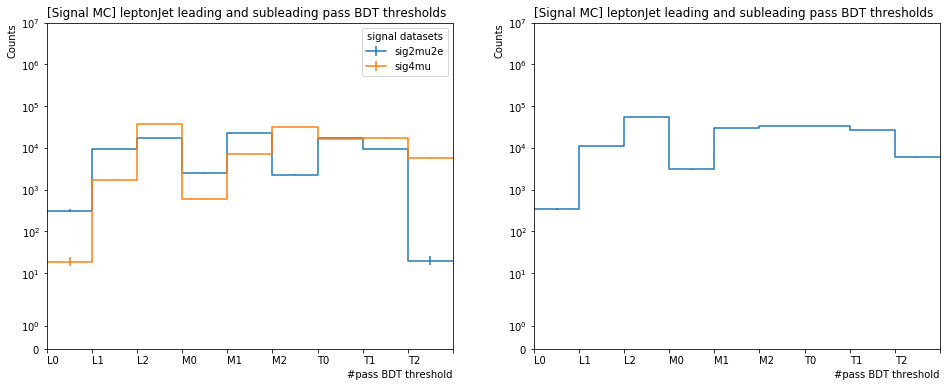

In [14]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['count'], ax=axes[0], overlay='dataset')
hist.plot1d(output['count'].sum('dataset'), ax=axes[1])

axes[0].set_ylim([0, 1e7])
axes[1].set_ylim([0, 1e7])

for ax in axes:
    ax.set_yscale('symlog')
    ax.set_xticklabels(['L0', 'L1', 'L2', 'M0', 'M1', 'M2', 'T0', 'T1', 'T2'],fontdict={'ha': 'left'})
    ax.set_title('[Signal MC] leptonJet leading and subleading pass BDT thresholds', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [15]:
for key, value in output['cutflow'].items():
    print(key, value)

all jets 929468
pass dark photon matching 740779
pass trigger and MET filter 358836
pass loose cut 340606
pass medium cut 294921
pass tight cut 124132
